# Bayesian Optimization
`````{admonition} Bayesian Optimization - Summary
:class: tip
- Optimizes expensive black-box functions
- Uses surrogate model (typically Gaussian Processes)
- Balance exploration vs exploitation via acquisition functions
- Efficient for hyperparameter tuning, experimental design, etc.
`````

## Definition
Bayesian Optimization is a strategy for optimizing expensive-to-evaluate functions. An example could be a Deep Neural Network

Consider the following scenario. We have to train a deep neural network for image classification. Our network's performance depends on different hyperparameters:
- Learning rate ($\eta$)
- Batch size (B)
- No. of hidden layers (L)
- Dropout probability (p)
- Weight decay ($\lambda$)

The problem is that each training run takes **hours** and the relationship between hyperparameters and accuracy is **nonlinear and unknown**. Is there a solution? Yes, Bayesian Optimization.

Bayesian Optimization treats the model performance (validation accuracy or loss) as a black-box function

$$
f(\eta, B, L, p, \lambda) = \text{Validation}.
$$

Since evaluating $f$ is expensive, BO builds a surrogate model (often a Gaussian Process) to capture the relationship between hyperaprameters and accuracy.

## Bayesian Optimization Workflow
Bayesian optimization effectively combines statistical modeling and decision-making strategies to optimize complex, costly functions.
### 1. Initialization
First we need to define the **search space** or the **span** of our hyperparameters. For instance:
- Learning rate: $[10^{-5}, 10^{-1}]$
- Batch size: $[32, 512]$
- Layers: $[2, 6]$
- Dropout: $[0.0, 0.5]$
- Weight decay: $[10^{-6}, 10^{-2}]$
Then we select a few initial points by sampling function $f$. 

### 2. Surrogate model
A **Gaussian Process (GP)** is typically used as the surrogate model. The GP is a powerful tool for **non-linear** and **non-parametric** estimation given its ability to provide both a mean $m(x)$ and an uncertainty measure $k(x, x')$ at any point in the input space. The GP models the function as:

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x')).
$$

Here:
- $m(x)$ is often assumed to be zero if no prior is known.
- $k(x,x')$ is the so-called *kernel* function and defined the covariance between any two points in the input space. There are many kernel functions available, a good reference is [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/).

### 3. Acquisition function
The next point to sample is chosen by maximizing an **acquisition function**, which balances **exploration** (trying regions where the model is uncertain) and **exploitation** (focusing on regions likely to yield improvements).

Intuitively, sticking close to already sampled points might reveal a better set of hyperparameters — but it might also miss the true optimum. Exploration ensures we also investigate uncertain areas, where the surrogate model suggests there could be undiscovered improvements.

Since any optimization problem can be expressed as either maximization or minimization (by flipping the sign of the objective), let us assume we want to maximize $f(x)$. Then, we can defined the **improvement** $I(x)$ at a point $x$ as

$$
I(x) = \text{max}(f(x)-f(x^*), 0),
$$

where $f(x^*)$ is the best solution we have so far. From this definition we can describe common acquisition functions.
#### Expected Improvement (EI)
The **expected improvement** is described as the expected value of $I(x)$ and is another random variable defined over the GP

$$
\text{EI}(x) = \mathbb{E}[I(x)] = \int_{-\infty}^{\infty} I(x)\varphi(z)dz,
$$

where $\varphi(z)$ is the probability density function of the standard distribution $\mathcal{N}(0,1)$. In practice, EI simplifies to a closed-form expression involving the surrogate’s predictive mean $\mu$ and standard deviation $\sigma$ as

$$
\left(\mu- f(x^\star)\right) \Phi\left(\frac{\mu-f(x^\star)}{\sigma}\right) + \sigma \varphi\left(\frac{\mu - f(x^\star)}{\sigma}\right).
$$

:::{admonition} **Derivation**
:class: tip, dropdown

We have

$$
\text{EI}(x) = \int_{-\infty}^{\infty} I(x)\varphi(z) \mathop{\mathrm{d}z}=\int_{-\infty}^{\infty}\underbrace{\max(f(x) - f(x^\star), 0)}_{I(x)}\varphi(z)\mathop{\mathrm{d}z}.
$$

How to compute "max" in the integral?
We want to find a switch point $z_0$ where the integral is splitted in two when $f(x) - f(x^*) \ge 0$ and the other $f(x) - f(x^*) \le 0$. That is

$$
\text{if} \quad f(x)=f(x^*) \Rightarrow \mu + \sigma z = f(x^*) \Rightarrow z_0 = \dfrac{f(x^*) - \mu}{\sigma}.
$$

So we can rewrite

$$
\text{EI}(x) = \underbrace{\int_{-\infty}^{z_0} I(x)\varphi(z) \mathop{\mathrm{d}z}}_{\text{Zero since }I(x)=0} + \int_{z_0}^{\infty} I(x)\varphi(z) \mathop{\mathrm{d}z}.
$$

Since we know that $f(x)=\mu+\sigma z$ and that $f(x)-f(x^*) \le 0$ only in $(-\infty, z_0)$, then

$$
\begin{aligned}
\text{EI}(x)
&=\int_{z_0}^{\infty} \max(f(x)-f(x^\star),0) \varphi(z)\mathop{\mathrm{d}z} =
\int_{z_0}^{\infty} \left(\mu+\sigma z - f(x^\star)\right)\varphi(z) \mathop{\mathrm{d}z}\\
&= \int_{z_0}^{\infty} \left(\mu - f(x^\star) \right)\varphi(z)\mathop{\mathrm{d}z} +
\int_{z_0}^{\infty} \sigma z \frac{1}{\sqrt{2\pi}}e^{-z^2/2}\mathop{\mathrm{d}z} \\\\
&=\left(\mu- f(x^\star)\right) \underbrace{\int_{z_0}^{\infty}\varphi(z)\mathop{\mathrm{d}z}}_{1-\Phi(z_0)\equiv 1-\text{CDF}(z_0)} + \frac{\sigma}{\sqrt{2\pi}}\int_{z_0}^{\infty}  z e^{-z^2/2}\mathop{\mathrm{d}z}\\
&=\left(\mu- f(x^\star)\right) (1-\Phi(z_0)) - \frac{\sigma}{\sqrt{2\pi}}\int_{z_0}^{\infty}  \left(e^{-z^2/2}\right)' \mathop{\mathrm{d}z}\\
&=\left(\mu- f(x^\star)\right) (1-\Phi(z_0)) - \frac{\sigma}{\sqrt{2\pi}} \left[e^{-z^2/2}\right]_{z_0}^{\infty}\\
&=\left(\mu- f(x^\star)\right) \underbrace{(1-\Phi(z_0))}_{\Phi(-z_0)} + \sigma \varphi(z_0) \\
&=\left(\mu- f(x^\star)\right) \Phi\left(\frac{\mu-f(x^\star)}{\sigma}\right) + \sigma \varphi\left(\frac{\mu - f(x^\star)}{\sigma}\right)
\end{aligned}
$$

```{note}
In probability, a Cumulative Distribution Function (CDF) is a function that gives the probability that a random variable will take a value less than or equal to a specific value.
```
This function takes high values when $\mu \ge f(x^*)$ or when there is a lot of uncertainty, when $\sigma \ge 1$. If we have a precise observation then $\sigma = 0$ and it holds that $\text{EI}(x) = 0$.

Source: [Acquisition functions in Bayesian Optimization](https://ekamperi.github.io/machine%20learning/2021/06/11/acquisition-functions.html).
:::

#### Upper Confidence Bound (UCB)
The **Upper Confidence Bound** acquisition function has a simple form. At a candidate point $x$ it is defined as:

$$
\text{UCB}(x) = \mu(x) + k\sigma(x),
$$

where $\mu(x)$ and $\sigma(x)$ are the mean and standard deviation of the GP's prediction at point $x$, while $k$ is a parameter that control the trade-off:
- Larger $k$ values emphasize exploration, encouraging sampling in regions with high uncertainty.
- Smaller $k$ values emphasize exploitation, focusing on regions where the surrogate predicts high performance.

### 4. Objective function
The next best-point candidate $x$ is evaluated to obtain $f(x)$. This new observation is added to the dataset, used to update the GP model.
### 5. Iteration and termination
The steps of updating the acquisition function, selecting new points, and updating the surrogate model are repeated. The optimization process continues until a predefined stopping criterion is met, such as reaching a maximum number of function evaluations or achieving a convergence threshold where the improvements become minimal.

Bayesian optimization is a tool to efficiently navigate complex functions landscapes, minimizing the number of evaluations needed to locate the optimum by intelligently balancing exploration of unknown regions and exploitation of promising areas.

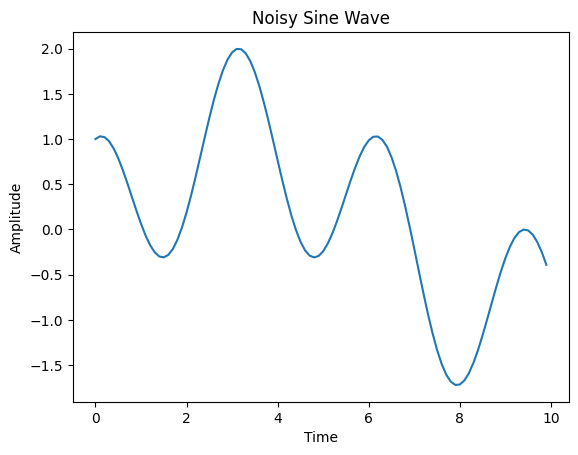

In [1]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(0, 10, 0.1)
f = np.sin(0.5 * t) + np.cos(2 * t)

plt.plot(t, f)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noisy Sine Wave')
plt.show()